In [91]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.manual_seed(42)
np.random.seed(42)

In [92]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compatibility with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


class GradCAM:
    def __init__(self,
                 model,
                 target_layers,
                 reshape_transform=None,
                 use_cuda=False):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    @staticmethod
    def get_cam_weights(grads):
        return np.mean(grads, axis=(2, 3), keepdims=True)

    @staticmethod
    def get_loss(output, target_category):
        loss = 0
        for i in range(len(target_category)):
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self, activations, grads):
        weights = self.get_cam_weights(grads)
        weighted_activations = weights * activations
        cam = weighted_activations.sum(axis=1)

        return cam

    @staticmethod
    def get_target_width_height(input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(self, input_tensor):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for layer_activations, layer_grads in zip(activations_list, grads_list):
            cam = self.get_cam_image(layer_activations, layer_grads)
            cam[cam < 0] = 0  # works like mute the min-max scale in the function of scale_cam_image
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result)

    @staticmethod
    def scale_cam_image(cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)

        return result

    def __call__(self, input_tensor, target_category=None):

        if self.cuda:
            input_tensor = input_tensor.cuda()
        output = self.activations_and_grads(input_tensor)
        if isinstance(target_category, int):
            target_category = [target_category] * input_tensor.size(0)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
            print(f"category id: {target_category}")
        else:
            assert (len(target_category) == input_tensor.size(0))

        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor)
        return self.aggregate_multi_layers(cam_per_layer)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def center_crop_img(img: np.ndarray, size: int):
    h, w, c = img.shape

    if w == h == size:
        return img

    if w < h:
        ratio = size / w
        new_w = size
        new_h = int(h * ratio)
    else:
        ratio = size / h
        new_h = size
        new_w = int(w * ratio)

    img = cv2.resize(img, dsize=(new_w, new_h))

    if new_w == size:
        h = (new_h - size) // 2
        img = img[h: h+size]
    else:
        w = (new_w - size) // 2
        img = img[:, w: w+size]

    return img


In [93]:
import requests
import matplotlib.pyplot as plt
model = models.convnext_tiny(weights=True)  # 或者使用預訓練模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(LABELS_URL).json()
data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

c:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [94]:
class image():
    def img(path):
        # Load image
        img_path = path
        assert os.path.exists(img_path), f"file: '{img_path}' does not exist."
        img = Image.open(img_path).convert('RGB')
        img = np.array(img, dtype=np.uint8)
        img = center_crop_img(img, 224)
        # Prepare input tensor
        img_tensor = data_transform(img)
        input_tensor = torch.unsqueeze(img_tensor, dim=0).to(device)
        return img , input_tensor

In [113]:
def Gradcam(img,input_tensor):
    # Forward pass to get feature maps
    with torch.no_grad():
        model(input_tensor)
    # Step 3: Model Prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        class_names = labels  # 此處應包含您模型對應的類別名稱
        predicted_label = class_names[predicted_class]  # 假設 class_names 是一個包含類別名稱的列表
    # Display prediction result
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    predicted_class = torch.argmax(output, dim=1).item()
    # 將需要顯示的層定義為一個列表
    target_layers = [model.features[i] for i in range(len(model.features))]

    # 創建一個圖像容器來顯示不同層的Grad-CAM
    fig, axes = plt.subplots(1, len(target_layers), figsize=(15, 5))

    # 逐層計算Grad-CAM並顯示
    for i, layer in enumerate(target_layers):
        cam = GradCAM(model=model, target_layers=[layer], use_cuda=torch.cuda.is_available())
        grayscale_cam = cam(input_tensor=input_tensor, target_category=predicted_class)
        grayscale_cam = grayscale_cam[0, :]

        # 將Grad-CAM結果疊加至原圖
        visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255., grayscale_cam, use_rgb=True)
        
        # 在子圖中顯示
        axes[i].imshow(visualization)
        axes[i].set_title(f"Layer {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

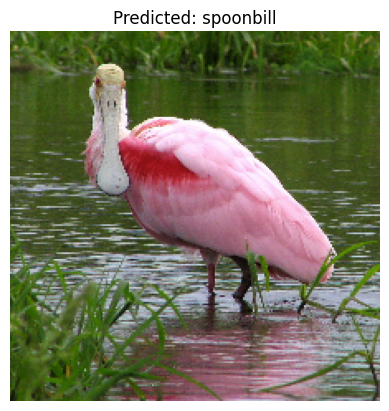

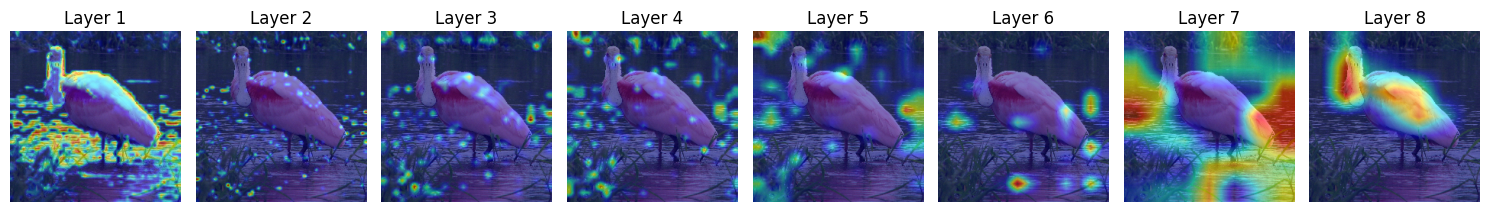

In [114]:
img ,tensor=image.img("image/spoonbill.jpg") # dog , Carcharodon , lorikeet , BlackWidow , spoonbill , GreenMamba
Gradcam(img ,tensor)